<a href="https://colab.research.google.com/github/elgranmuzzy/formality_style_transfer/blob/main/Formality_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import random

In [2]:
import pandas as pd

In [3]:
import numpy as np

In [4]:
import torch

In [5]:
import matplotlib.pyplot as plt

In [6]:
import seaborn as sns

In [7]:
from scipy.stats import ttest_ind, f_oneway, pearsonr

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [10]:
homepath = "/content/drive/MyDrive/HSE/Project2"

# Preparing data

Reddit Comments Dataset for Text Style Transfer Tasks: https://zenodo.org/records/8051180

The dataset contains Reddit comments translated into a formal language. For the translation of Reddit comments into a formal language text-davinci-003 was used.

In [26]:
data_dir = homepath + "/Reddit Comments Dataset"

In [27]:
# training data
train_df = pd.read_csv(data_dir + "/training_labeled.csv")
train_df.drop("Subreddit", axis =1, inplace=True)
train_df.columns = ["source", "target"]

In [13]:
train_df

,source,target
0,r/isthisanothersubifellfor,Is this another sub I fell for?
1,Sounds like you’re working car sales persons s...,It appears that you are working a schedule sim...
2,Boss watching too much Rupert on Ted Lasso.,"Boss is watching a lot of the show Ted Lasso, ..."
3,Immature and racist who could have guessed sta...,"People can be immature and have prejudices, bu..."
4,Reply “ you can get sued”.,It is possible to face legal action.
...,...,...
2366,Y’all this is clearly a pedo trying to get som...,This individual appears to be attempting to ob...
2367,l I respect women. Yer having shad thrown at m...,I have been treated disrespectfully by some te...
2368,The shock would sent the blood flying out the ...,The force of the impact caused the blood to sp...
2369,Today may be shit but your whole life isn’t sh...,"Today may not be the best day, but it doesn't ..."


In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2371 entries, 0 to 2370
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   source  2371 non-null   object
 1   target  2371 non-null   object
dtypes: object(2)
memory usage: 37.2+ KB


In [17]:
# cleaning data
def clean_df(df):
    # replacing HTML ampersand and whitespace with corresponding chars
    df["source"] = df["source"].str.replace(r"&amp;", "and", regex=True).\
    replace(r"&?#x200B;", " ", regex=True)

    # cleaning HTML special characters, asterisks and smileys off source
    clean_source_regex = r"&[\w#]+;|\*+|[\U00001F00-\U0001FAFF]+"
    df["source"] = df["source"].str.replace(clean_source_regex, "", regex=True)

    # deleting remnants of the training prompt from target
    clean_target_regex = r"Here is some text: "
    df["target"] = df["target"].str.replace(clean_target_regex, "", regex=True)

    # deleting rows with image placeholders and reddit channel refs
    delete_rows_regex = r"\!\[(?:gif|img)\]|r/"
    rows_to_delete = df[df["source"].str.contains(delete_rows_regex)].index
    df.drop(rows_to_delete, inplace=True)

In [28]:
# cleaning training DF
clean_df(train_df)

In [29]:
train_df

,source,target
1,Sounds like youre working car sales persons sc...,It appears that you are working a schedule sim...
2,Boss watching too much Rupert on Ted Lasso.,"Boss is watching a lot of the show Ted Lasso, ..."
3,Immature and racist who could have guessed sta...,"People can be immature and have prejudices, bu..."
4,Reply you can get sued.,It is possible to face legal action.
5,Specially to the interns? LOL,"To the interns, this is especially for you! Ha..."
...,...,...
2366,Yall this is clearly a pedo trying to get some...,This individual appears to be attempting to ob...
2367,l I respect women. Yer having shad thrown at m...,I have been treated disrespectfully by some te...
2368,The shock would sent the blood flying out the ...,The force of the impact caused the blood to sp...
2369,Today may be shit but your whole life isnt shi...,"Today may not be the best day, but it doesn't ..."


In [30]:
# testing data
test_df = pd.read_csv(data_dir + "/eval_labeled.csv")
test_df.drop("Subreddit", axis =1, inplace=True)
test_df.columns = ["source", "target"]

In [31]:
# cleaning testing DF
clean_df(test_df)

In [32]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 581 entries, 0 to 599
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   source  581 non-null    object
 1   target  581 non-null    object
dtypes: object(2)
memory usage: 13.6+ KB


In [33]:
test_df

,source,target
0,Isnt that stating the obvs ?,"That seems to be an obvious statement, doesn't..."
2,Getting down oted for this comment just proves it,This comment has been noted and appreciated.
3,Cant pass laws that help average citizens!,It is not possible to pass laws that benefit t...
4,Liz Cheny and Adam Kiplinger's would disagree,Liz Cheney and Adam Kiplinger have differing o...
5,What does ctrl F and Peter Thompson mean? Just...,What is the relationship between the use of th...
...,...,...
595,A correction. SK approved the re-export of tho...,SK authorized the re-export of Krab SPGs conta...
596,I'd 100% trust US Intelligence Don't see that ...,I would have a high level of confidence in US ...
597,Probably the kind where your whole family disa...,Your family could be in danger if a relative r...
598,Im starting to think Zapp Branagan had the rig...,I'm starting to consider that Zapp Branagan ha...


# Loading a T5 paraphraser model

In [23]:
# The model is claimed to be one of the best paraphrases on Hugging Face.
tokenizer = AutoTokenizer.from_pretrained("humarin/chatgpt_paraphraser_on_T5_base")

model = AutoModelForSeq2SeqLM.from_pretrained("humarin/chatgpt_paraphraser_on_T5_base").to(device)


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [21]:
# invoking the model: input = prefix + source_txt
def generate_sentence(s, prefix, is_prefixed=True):
    inputs = tokenizer(prefix + s if is_prefixed else s, return_tensors="pt").input_ids.to(device)
    outputs = model.generate(inputs, max_length=128, no_repeat_ngram_size=2) #, num_return_sequences=3, num_beams=3, num_beam_groups=3, diversity_penalty=3.0)
    return tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

In [28]:
generate_sentence("Here's a test sentence.", "paraphase: ", model)

"Here's a sample sentence."

## Generating sentences w/ pretrained model

In [24]:
# pt = Pre-Trained
test_df["pt"] = test_df.source.apply(lambda x: generate_sentence(x, "paraphase: "))

In [30]:
test_df.head()

,source,target,pt
0,Isnt that stating the obvs ?,"That seems to be an obvious statement, doesn't...",Is that not exaggerated?
2,Getting down oted for this comment just proves it,This comment has been noted and appreciated.,The fact that you are being cheated for this c...
3,Cant pass laws that help average citizens!,It is not possible to pass laws that benefit t...,Is unable to pass laws that benefit the common...
4,Liz Cheny and Adam Kiplinger's would disagree,Liz Cheney and Adam Kiplinger have differing o...,Liz Cheny and Adam Kiplinger's opposes.
5,What does ctrl F and Peter Thompson mean? Just...,What is the relationship between the use of th...,I'm wondering about the meaning of ctrl F and ...


# Fine-tuning the paraphraser model

## Training loop

In [37]:
optimizer = torch.optim.AdamW(params=[p for p in model.parameters() if p.requires_grad], lr=2e-5)

In [32]:
# using a new prefix
prefix = "formalize: "

In [33]:
# texts to lists
source_train = [prefix + i.strip() for i in train_df['source'].tolist()]
target_train = [i.strip() for i in train_df['target'].tolist()]

In [34]:
# list of tuples: [(source, target),]
lines = list(zip(source_train, target_train))

In [35]:
# getting the batch: (source, target)
def get_batch(sentence):
    return sentence[0], sentence[1]

In [38]:
%%time
# training loop

iterations = 10000

all_loss = 0

for i in range(iterations):
    xx, yy = get_batch(random.choice(lines))
    x = tokenizer(xx, return_tensors='pt', padding=True).to(model.device)
    y = tokenizer(yy, return_tensors='pt', padding=True).to(model.device)
    # setting (-100) for masked tokens
    y.input_ids[y.input_ids==0] = -100
    loss = model(
        input_ids=x.input_ids,
        attention_mask=x.attention_mask,
        labels=y.input_ids,
        decoder_attention_mask=y.attention_mask,
        return_dict=True
    ).loss
    loss.backward()
    all_loss += loss.item()
    optimizer.step()
    optimizer.zero_grad()

    # progress report every 1000 steps
    if ((i + 1) % 1000 == 0):
      print('Step: {0}, loss: {1}'.format(i + 1, all_loss / (i + 1)))

Step: 1000, loss: 0.7857367261052132
Step: 2000, loss: 0.7125126504905056
Step: 3000, loss: 0.6326704792757518
Step: 4000, loss: 0.5785907771286438
Step: 5000, loss: 0.528362999576307
Step: 6000, loss: 0.4835796534345524
Step: 7000, loss: 0.439984933048046
Step: 8000, loss: 0.4029294055179853
Step: 9000, loss: 0.3734947956555924
Step: 10000, loss: 0.3450133389628958
CPU times: user 27min 57s, sys: 4.4 s, total: 28min 1s
Wall time: 28min 5s


## Saving model

In [39]:
path_to_model = homepath + "/model_save"

In [40]:
# Saving model
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = path_to_model #'./model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to /content/drive/MyDrive/HSE/Project2/model_save


('/content/drive/MyDrive/HSE/Project2/model_save/tokenizer_config.json',
 '/content/drive/MyDrive/HSE/Project2/model_save/special_tokens_map.json',
 '/content/drive/MyDrive/HSE/Project2/model_save/spiece.model',
 '/content/drive/MyDrive/HSE/Project2/model_save/added_tokens.json',
 '/content/drive/MyDrive/HSE/Project2/model_save/tokenizer.json')

In [41]:
# !zip trained_model.zip ./model_save/*

In [42]:
# !unzip /content/drive/MyDrive/HSE/Project2/trained_model.zip -d /content/drive/MyDrive/HSE/Project2/

In [43]:
prefix = "formalize: "

In [44]:
s = "What the hell is going on?!"

In [45]:
generate_sentence(s, prefix)

'What is going on?'

## Loading model

In [14]:
path_to_model = homepath + "/model_save"

In [15]:
tokenizer = AutoTokenizer.from_pretrained(path_to_model)

model = AutoModelForSeq2SeqLM.from_pretrained(path_to_model).to(device)

## Generating sentences w/ fine-tuned model

In [22]:
# ft = Fine-Tuned
test_df["ft"] = test_df.source.apply(lambda x: generate_sentence(x, "formalize: "))

In [47]:
test_df.head()

,source,target,pt,ft
0,Isnt that stating the obvs ?,"That seems to be an obvious statement, doesn't...",Is that not exaggerated?,That sure looks like the original.
2,Getting down oted for this comment just proves it,This comment has been noted and appreciated.,The fact that you are being cheated for this c...,It appears that commenting on this comment is ...
3,Cant pass laws that help average citizens!,It is not possible to pass laws that benefit t...,Is unable to pass laws that benefit the common...,It is not possible to pass laws that benefit o...
4,Liz Cheny and Adam Kiplinger's would disagree,Liz Cheney and Adam Kiplinger have differing o...,Liz Cheny and Adam Kiplinger's opposes.,Liz Cheny and Adam Kiplinger's opinions differed.
5,What does ctrl F and Peter Thompson mean? Just...,What is the relationship between the use of th...,I'm wondering about the meaning of ctrl F and ...,What does the acronym F mean? (Peri Thompson)


In [48]:
test_df.to_csv(homepath + "/test_df.csv", index_label = "index")

# LLM

In [107]:
# Restoring from backup if DataFrame does not exist
if 'test_df' not in globals():
    test_df = pd.read_csv(homepath + "/test_df.csv" , index_col = 0)

In [108]:
%%capture
! pip install langchain-gigachat #langchain-community langchain-huggingface

In [109]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_gigachat.chat_models import GigaChat

In [110]:
with open(homepath + '/gigachat_auth_key.txt', 'r') as f:
    api_key = f.read().strip()

In [111]:
llm_model = GigaChat(
    model='GigaChat-2', #-Max',
    credentials=api_key,
    verify_ssl_certs=False,
)

In [112]:
def llm_rephrase(s, mdl):
    prompt = "Rewrite the following text in a more formal style:\n"
    messages = [
        SystemMessage(
            content="You are a Text Style Transfer model."
        ),
        HumanMessage(content=prompt + s),
    ]

    return mdl.invoke(messages, timeout=3000).content


In [116]:
text = "Hey, how r u doin'?"

In [117]:
llm_rephrase(text, llm_model)

'Hello, how are you doing?'

In [ ]:
# Generating formal versions of the train texts
# Oops: some sensitive politics-related topics are blacklisted in GigaChat!
test_df["llm"] = test_df.source.apply(lambda x: llm_rephrase(x, llm_model))

In [ ]:
# post-processing to remove LLM artifacts (blacklist message etc.)
test_df.llm[test_df['llm'].str.contains(r"[А-Яа-я]")] = ""

In [ ]:
test_df

In [ ]:
# Backing-up
test_df.to_csv(homepath + "/test_df.csv", index_label = "index")

# LLM2

In [177]:
# Restoring from backup if DataFrame non-existent
if 'test_df' not in globals():
    test_df = pd.read_csv(homepath + "/test_df.csv" , index_col = 0)

In [178]:
with open(homepath + '/deepseek_key.txt', 'r') as f:
    api_key2 = f.read().strip()

In [179]:
# import getpass
import os

if not os.getenv("DEEPSEEK_API_KEY"):
    os.environ["DEEPSEEK_API_KEY"] = api_key2 #getpass.getpass("Enter your DeepSeek API key: ")

In [180]:
%%capture
%pip install -qU langchain-deepseek

In [181]:
from langchain_deepseek import ChatDeepSeek

llm = ChatDeepSeek(
    model="deepseek-chat",
    temperature=1.3,
    max_tokens=128,
    timeout=None,
    max_retries=2,
    # other params...
)

In [182]:
messages = [
    (
        "system",
        "You are a Text Style Transfer model. Rewrite the user text in a more formal style.",
    ),
    ("human", "Hey, how ya' doin'?"),
]
ai_msg = llm.invoke(messages)
ai_msg.content

'Good day. How are you doing?  \n\nThis version maintains a polite and professional tone while removing the casual contractions and informal phrasing.  \n\nWould you like me to adjust the level of formality further?'

In [183]:
# rephrasing with LLM: asking explicitly to generate just text
def llm_rephrase(s, mdl):
    messages = [
        (
            "system",
            "You are a Text Style Transfer model. Rewrite the user text in a more formal style. I need just one version of the text without any comments from you.",
        ),
        ("human", s),
    ]
    ai_msg = mdl.invoke(messages)
    return ai_msg.content

In [184]:
# an example sentence from the train data-set
llm_rephrase("Lol all historians believe this Links to Wikipedia", llm)

'All historians universally acknowledge this assertion, as substantiated by references to Wikipedia.'

In [185]:
# Generating formal versions of the train texts
test_df["llm2"] = test_df.source.apply(lambda x: llm_rephrase(x, llm))

In [25]:
# Backing-up
test_df.to_csv(homepath + "/test_df.csv", index_label = "index")

# Calculating scores

In [36]:
# Restoring from backup if DataFrame non-existent
if 'test_df' not in globals():
    test_df = pd.read_csv(homepath + "/test_df.csv" , index_col = 0)

In [37]:
test_df.head(12)

,source,target,pt,ft,llm,llm2
index,,,,,,
0,Isnt that stating the obvs ?,"That seems to be an obvious statement, doesn't...",Is that not exaggerated?,That sure looks like the original.,Isn't that stating the obvious?,Is that not stating the obvious?
2,Getting down oted for this comment just proves it,This comment has been noted and appreciated.,The fact that you are being cheated for this c...,It appears that commenting on this comment is ...,Addressing the issue regarding this comment un...,Receiving negative feedback on this comment on...
3,Cant pass laws that help average citizens!,It is not possible to pass laws that benefit t...,Is unable to pass laws that benefit the common...,It is not possible to pass laws that benefit o...,Cannot enact legislation that benefits ordinar...,The legislature is unable to enact policies th...
4,Liz Cheny and Adam Kiplinger's would disagree,Liz Cheney and Adam Kiplinger have differing o...,Liz Cheny and Adam Kiplinger's opposes.,Liz Cheny and Adam Kiplinger's opinions differed.,Liz Cheny's and Adam Kiplinger would likely di...,Liz Cheney and Adam Kinzinger would likely exp...
5,What does ctrl F and Peter Thompson mean? Just...,What is the relationship between the use of th...,I'm wondering about the meaning of ctrl F and ...,What does the acronym F mean? (Peri Thompson),What is the significance of Ctrl+F and its ass...,The functions of the Ctrl+F keyboard shortcut ...
6,D00d take me! 44 and lost all my live show bud...,Let's go! I'm missing all my friends from the ...,I've lost all my friends during live shows.,I'm going to be a part of '44 Live Show' and m...,Kindly assist me; I am seeking guidance. Forty...,"I regret to inform you that, at the age of 44,..."
7,Theres no might. Five years max.,There is no room for uncertainty; the timeline...,The possibility of a five-year break is non-ex...,There is no potential for success.,There is no uncertainty. A maximum duration of...,There is no uncertainty. The maximum duration ...
8,Something starting with 'ped' involved for sur...,There is something that involves 'ped' for sur...,It is certain that something with the word 'pe...,Something that begins with the letter 'ped' is...,"Something commencing with ""ped"" is undoubtedly...",It is certain that an element beginning with '...
9,states banning school lunches. wat?,Some states have implemented policies that res...,What are the factors that make school lunches ...,Some states have banned school lunches. What a...,Certain states have enacted legislation prohib...,Several states have implemented policies prohi...


## Formality

In [38]:
# The model has been trained to predict for English sentences, whether they are formal or informal.
from transformers import AutoTokenizer, AutoModelForSequenceClassification

form_tokenizer = AutoTokenizer.from_pretrained("s-nlp/roberta-base-formality-ranker")
form_model = AutoModelForSequenceClassification.from_pretrained("s-nlp/roberta-base-formality-ranker").to(device)

tokenizer_config.json:   0%|          | 0.00/288 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/827 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [39]:
# returns the formality probability
def form_score(s):
    # checking for NaN's
    if isinstance(s, str) and len(s):
        inputs = form_tokenizer(s, return_tensors="pt").input_ids.to(device)
        return form_model(inputs).logits.softmax(1).tolist()[0][1]
    else:
        return float('nan')


In [40]:
form_score("Just look where you're goin'!")

0.008418846875429153

In [41]:
form_score("I love you!")

0.4806651473045349

In [42]:
form_score("We would appreciate it if you could pay a visit to us.")

0.9963860511779785

In [43]:
# formality score DF
form_df = pd.DataFrame(columns = test_df.columns)

for column in test_df:
    form_df[column] = test_df[column].apply(form_score)

In [44]:
form_df.head(12)

,source,target,pt,ft,llm,llm2
index,,,,,,
0,0.239908,0.777771,0.995684,0.393155,0.986572,0.992138
2,0.167477,0.868586,0.996366,0.996320,0.987471,0.907578
3,0.177471,0.996242,0.947644,0.963533,0.486393,0.778164
4,0.617384,0.895711,0.300486,0.575856,0.689508,0.933300
5,0.967597,0.996919,0.996483,0.891125,0.996871,0.997194
6,0.042458,0.943906,0.883010,0.742014,0.996704,0.996652
7,0.307468,0.855202,0.988850,0.996615,0.996908,0.996902
8,0.007241,0.016795,0.988972,0.994686,0.993579,0.996952
9,0.170916,0.940314,0.989029,0.990172,0.996949,0.929456


In [45]:
form_df.describe()

,source,target,pt,ft,llm,llm2
count,581.000000,581.000000,581.000000,581.000000,522.000000,581.000000
mean,0.342423,0.871860,0.756874,0.838114,0.912157,0.928416
std,0.281505,0.194468,0.259003,0.227674,0.162591,0.133334
min,0.004905,0.016795,0.008243,0.013512,0.094726,0.115136
25%,0.132992,0.811311,0.564253,0.732092,0.907257,0.929442
50%,0.267996,0.982976,0.850788,0.979113,0.994174,0.994822
75%,0.481856,0.996330,0.992167,0.995956,0.996746,0.996718
max,0.996913,0.997531,0.997371,0.997526,0.997439,0.997347


array([[<Axes: title={'center': 'source'}>,
        <Axes: title={'center': 'target'}>],
       [<Axes: title={'center': 'pt'}>, <Axes: title={'center': 'ft'}>],
       [<Axes: title={'center': 'llm'}>,
        <Axes: title={'center': 'llm2'}>]], dtype=object)

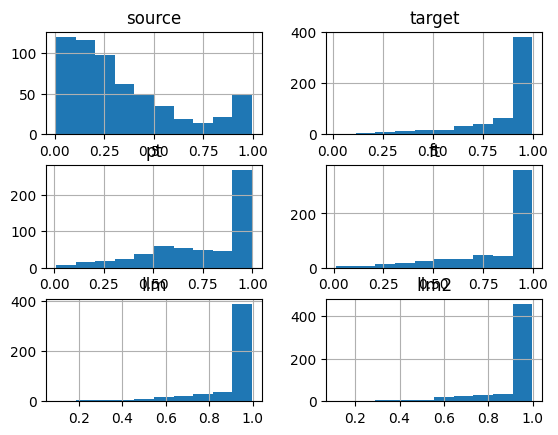

In [46]:
form_df.hist()

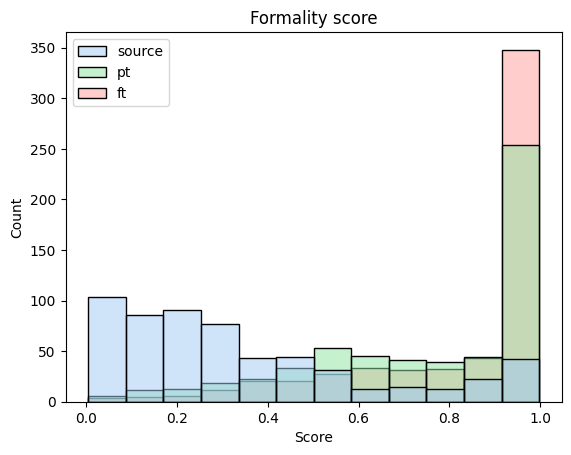

In [47]:
ax = sns.histplot(data=form_df[["source", "pt", "ft"]],
                  palette=list(np.array(sns.color_palette("pastel"))[[0, 2, 3]]),
                  alpha=.5)
plt.xlabel("Score")
plt.title("Formality score")
plt.show()

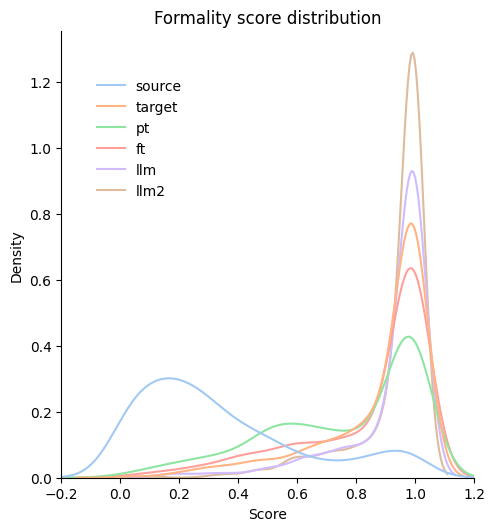

In [48]:
ax = sns.displot(data=form_df, kind="kde", palette='pastel')
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.15, 0.9))
plt.xlim(-0.2, 1.2)
plt.xlabel("Score")
plt.title("Formality score distribution")
plt.show()

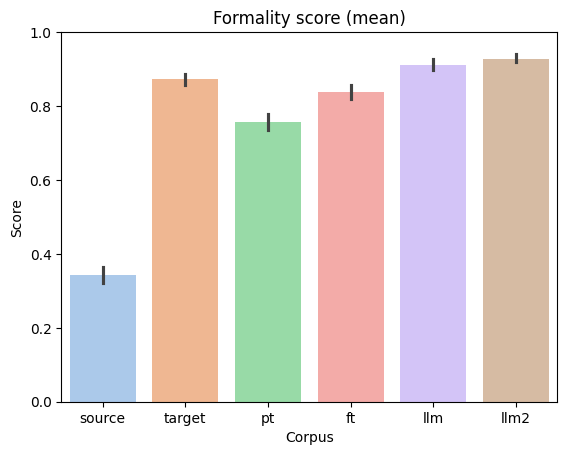

In [49]:
sns.barplot(data=form_df, palette='pastel')
plt.ylim(0, 1)
plt.xlabel("Corpus")
plt.ylabel("Score")
plt.title("Formality score (mean)")
plt.show()

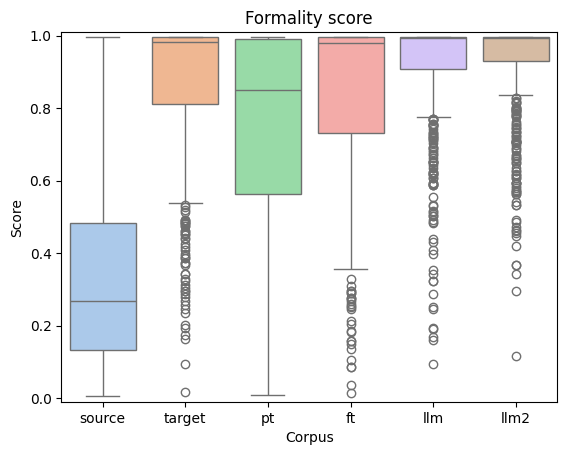

In [50]:
sns.boxplot(data=form_df, palette='pastel')
plt.ylim(-0.01, 1.01)
plt.xlabel("Corpus")
plt.ylabel("Score")
plt.title("Formality score")
plt.show()

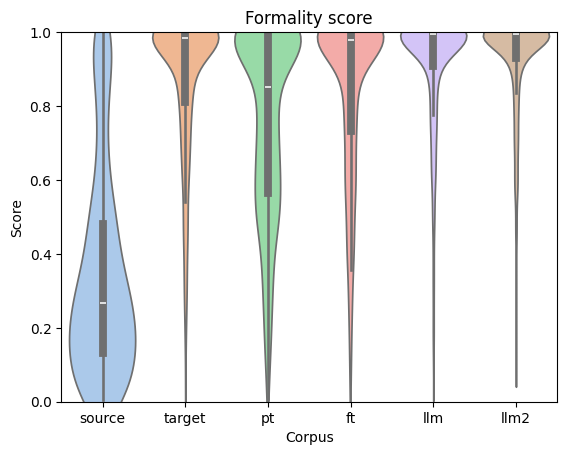

In [51]:
sns.violinplot(data=form_df, palette='pastel')
plt.ylim(0, 1)
plt.xlabel("Corpus")
plt.ylabel("Score")
plt.title("Formality score")
plt.show()

In [37]:
# Welch’s t-test (one-sided):
# H0 = no difference between the pre-trained and fine-tuned model generated text formality level
t_result = ttest_ind(form_df.pt, form_df.ft,
                     equal_var=False,
                     alternative='less')
print(f"T-statistic: {t_result.statistic}")
print(f"P-value: {t_result.pvalue}")

T-statistic: -5.678522091842101
P-value: 8.612780186336303e-09


In [53]:
# one-way ANOVA
f_oneway(form_df.source, form_df.target, form_df.pt, form_df.ft)

F_onewayResult(statistic=np.float64(589.8643031763858), pvalue=np.float64(6.6120585978866516e-285))

In [54]:
# Backing-up
form_df.to_csv(homepath + "/form_df.csv")

In [20]:
form_df = pd.read_csv(homepath + "/form_df.csv", index_col = 0)

## Semantic similarity

### Sentence Transformer (cos-sim)

In [56]:
# best model from https://www.sbert.net/docs/sentence_transformer/pretrained_models.html
from sentence_transformers import SentenceTransformer, util

sim_model = SentenceTransformer('all-mpnet-base-v2').to(device)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [57]:
# similarity score (cos-sim)
def sim_score(ss, mdl):
    # checking for NaN's
    if all(map(lambda x: isinstance(x, str) and len(x), ss)):
        return util.cos_sim(*mdl.encode(ss)).item()
    else:
        return float('nan')

sim_score(["I love programming", "Coding is my passion"], sim_model)

0.7909291386604309

In [58]:
# similarity score DF
sim_df = pd.DataFrame()

for column in test_df:
    if column != "source":
        sim_df[column] = test_df.apply(lambda x: sim_score([x["source"], x[column]], sim_model), axis=1)

In [59]:
sim_df.head(12)

,target,pt,ft,llm,llm2
index,,,,,
0,0.253833,0.215558,0.114983,0.391407,0.431712
2,0.168963,0.252594,0.285508,0.235384,0.421471
3,0.678459,0.688640,0.668887,0.837510,0.678464
4,0.550275,0.581361,0.605997,0.717732,0.340631
5,0.785131,0.965534,0.618430,0.828539,0.650292
6,0.599167,0.494668,0.646130,0.288830,0.453326
7,0.462657,0.370935,0.187175,0.450726,0.480681
8,0.878049,0.837138,0.836588,0.807184,0.665429
9,0.843912,0.799122,0.853810,0.780997,0.840589


In [60]:
sim_df.describe()

,target,pt,ft,llm,llm2
count,581.000000,581.000000,581.000000,522.000000,581.000000
mean,0.696269,0.737946,0.699816,0.715364,0.698398
std,0.165898,0.161603,0.187237,0.157273,0.158094
min,0.016087,0.077859,0.037708,0.016087,0.111268
25%,0.589915,0.661768,0.591985,0.632714,0.609639
50%,0.726133,0.773231,0.743529,0.744793,0.733178
75%,0.824403,0.848267,0.837876,0.824735,0.812596
max,0.975465,0.988093,1.000000,1.000000,0.974663


array([[<Axes: title={'center': 'target'}>,
        <Axes: title={'center': 'pt'}>],
       [<Axes: title={'center': 'ft'}>, <Axes: title={'center': 'llm'}>],
       [<Axes: title={'center': 'llm2'}>, <Axes: >]], dtype=object)

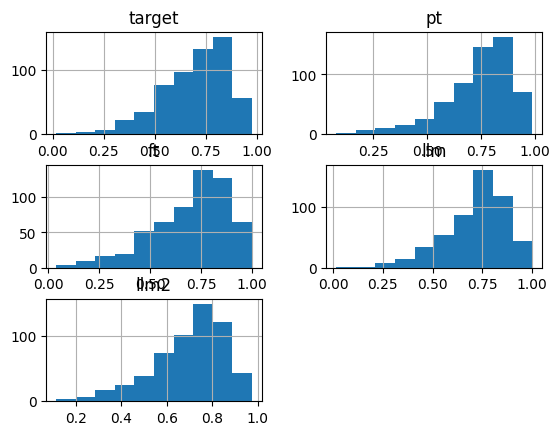

In [61]:
sim_df.hist()

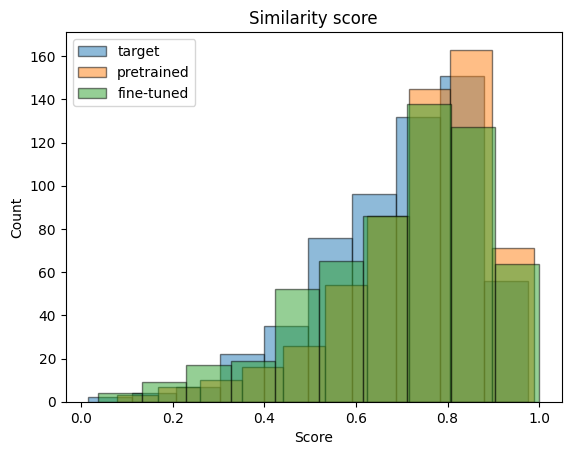

In [62]:
plt.hist(sim_df.target, edgecolor='k', alpha=.5, label="target")
plt.hist(sim_df.pt, edgecolor='k', alpha=.5, label="pretrained")
plt.hist(sim_df.ft, edgecolor='k', alpha=.5, label="fine-tuned")
plt.legend()
plt.ylabel("Count")
plt.xlabel("Score")
plt.title("Similarity score")
plt.show()

In [63]:
# to start from color #2
pal2 = sns.color_palette("pastel")[1:6]

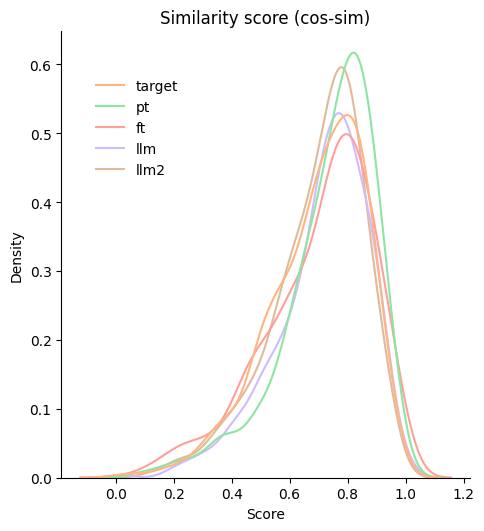

In [64]:
ax = sns.displot(data=sim_df, kind="kde", palette=pal2)
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.15, 0.9))
plt.xlabel("Score")
plt.title("Similarity score (cos-sim)")
plt.show()

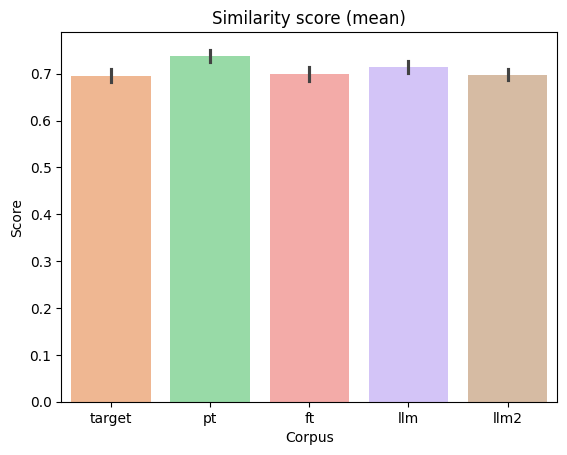

In [65]:
sns.barplot(data=sim_df, palette=pal2)
# plt.ylim(0, 1)
plt.xlabel("Corpus")
plt.ylabel("Score")
plt.title("Similarity score (mean)")
plt.show()

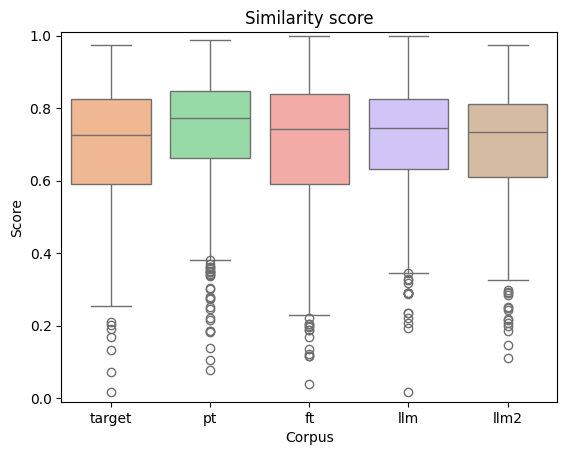

In [66]:
sns.boxplot(data=sim_df, palette=pal2)
plt.ylim(-.01, 1.01)
plt.xlabel("Corpus")
plt.ylabel("Score")
plt.title("Similarity score")
plt.show()

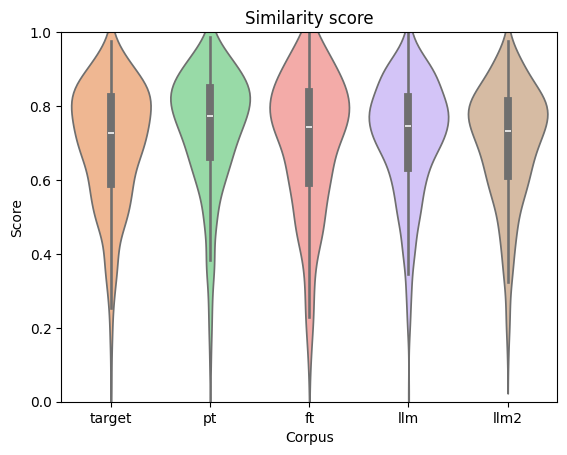

In [67]:
sns.violinplot(data=sim_df, palette=pal2)
plt.ylim(0, 1)
plt.xlabel("Corpus")
plt.ylabel("Score")
plt.title("Similarity score")
plt.show()

In [68]:
# Welch’s t-test
# H0 = no difference between the pre-trained and fine-tuned model generated text similarity level
t_result = ttest_ind(sim_df.pt, sim_df.ft, equal_var=False)
print(f"T-statistic: {t_result.statistic}")
print(f"P-value: {t_result.pvalue}")

T-statistic: 3.7160576627931503
P-value: 0.00021220853334478622


In [69]:
# one-way ANOVA
f_oneway(sim_df.target, sim_df.pt, sim_df.ft)

F_onewayResult(statistic=np.float64(10.492492229533688), pvalue=np.float64(2.9541192915209453e-05))

In [70]:
# Backing-up
sim_df.to_csv(homepath + "/sim_df.csv")

In [71]:
sim_df = pd.read_csv(homepath + "/sim_df.csv", index_col = 0)

### BERT-score

https://github.com/Tiiiger/bert_score

https://huggingface.co/spaces/evaluate-metric/bertscore

In [72]:
%%capture
!pip install evaluate

In [73]:
%%capture
!pip install bert-score

In [74]:
from evaluate import load
bertscore = load("bertscore")

In [75]:
predictions = ["Is that not stating the obvious?", "Receiving negative feedback for this comment serves as clear evidence of the point being made."]
references = ["Isnt that stating the obvs ?", "Getting down oted for this comment just proves it"]


In [76]:
results = bertscore.compute(predictions=predictions, references=references, model_type="microsoft/deberta-xlarge-mnli") #"distilbert-base-uncased")
results

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/792 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.04G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.04G [00:00<?, ?B/s]

{'precision': [0.8574541807174683, 0.6807424426078796],
 'recall': [0.8173646330833435, 0.711754560470581],
 'f1': [0.8369296193122864, 0.6959031224250793],
 'hashcode': 'microsoft/deberta-xlarge-mnli_L40_no-idf_version=0.3.12(hug_trans=4.52.4)'}

In [77]:
# BERT score: the MS model is ranked #1
def bert_score(src, tgt):
    # checking for NaN's
    if isinstance(tgt, str) and len(tgt):
        return bertscore.compute(predictions=[tgt], references=[src], model_type="microsoft/deberta-xlarge-mnli")["f1"][0]
    else:
        return float('nan')


In [78]:
bert_score("I love programming", "Coding is my passion")

0.7143769264221191

In [79]:
bert_score("I love programming", "How is it going?")

0.4020664691925049

In [80]:
# similarity score DF
bert_df = pd.DataFrame()

for column in test_df:
    if column != "source":
        bert_df[column] = test_df.apply(lambda x: bert_score(x["source"], x[column]), axis=1)

In [81]:
bert_df.head(12)

,target,pt,ft,llm,llm2
index,,,,,
0,0.672165,0.665822,0.556219,0.872922,0.836930
2,0.525931,0.650975,0.543602,0.672391,0.751952
3,0.854347,0.866407,0.872175,0.939358,0.814958
4,0.770886,0.751073,0.791334,0.884105,0.814239
5,0.821467,0.787165,0.722399,0.756968,0.631487
6,0.599866,0.636311,0.545775,0.572781,0.528754
7,0.718994,0.619216,0.640783,0.757136,0.757431
8,0.805795,0.800312,0.783419,0.722503,0.843777
9,0.684350,0.717989,0.781094,0.690226,0.739441


In [82]:
bert_df.describe()

,target,pt,ft,llm,llm2
count,581.000000,581.000000,581.000000,522.000000,581.000000
mean,0.712717,0.735914,0.721640,0.735846,0.722422
std,0.096709,0.088767,0.107038,0.092131,0.095548
min,0.351540,0.384190,0.355917,0.303901,0.338788
25%,0.650450,0.670565,0.646800,0.682560,0.662546
50%,0.715219,0.741029,0.724347,0.738562,0.726768
75%,0.783025,0.795014,0.798142,0.799465,0.784909
max,0.926804,0.983077,1.000000,1.000000,0.946183


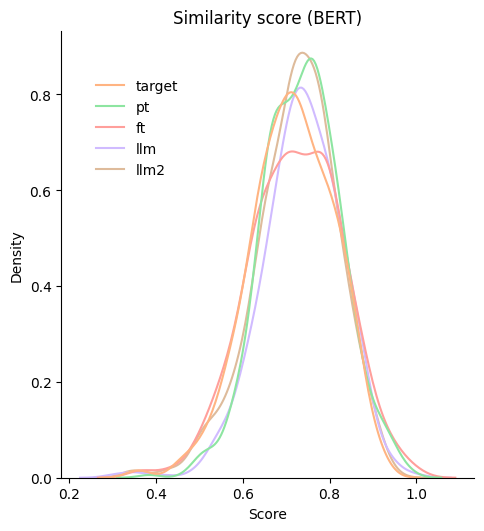

In [83]:
ax = sns.displot(data=bert_df, kind="kde", palette=pal2)
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.15, 0.9))
plt.xlabel("Score")
plt.title("Similarity score (BERT)")
plt.show()

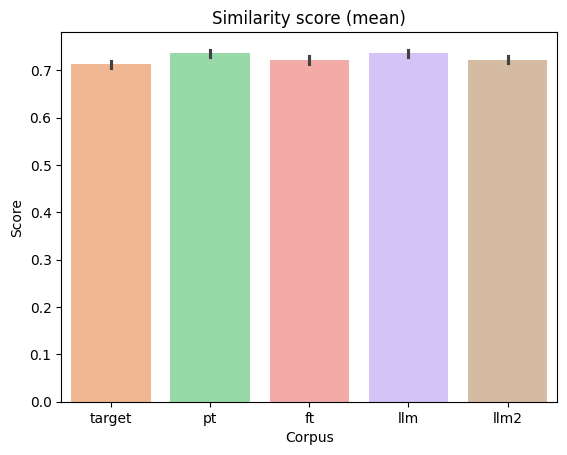

In [84]:
sns.barplot(data=bert_df, palette=pal2)
# plt.ylim(0, 1)
plt.xlabel("Corpus")
plt.ylabel("Score")
plt.title("Similarity score (mean)")
plt.show()

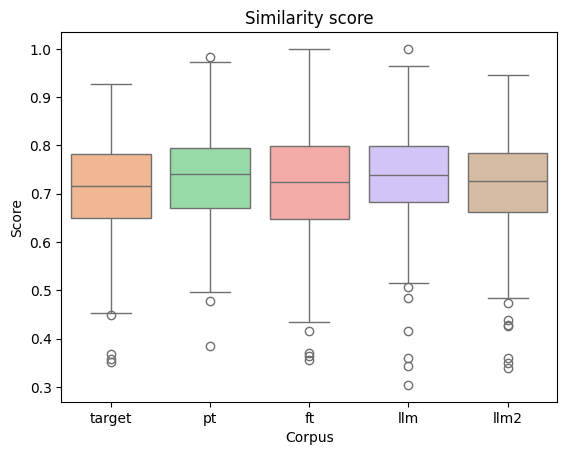

In [85]:
sns.boxplot(data=bert_df, palette=pal2)
# plt.ylim(0, 1)
plt.xlabel("Corpus")
plt.ylabel("Score")
plt.title("Similarity score")
plt.show()

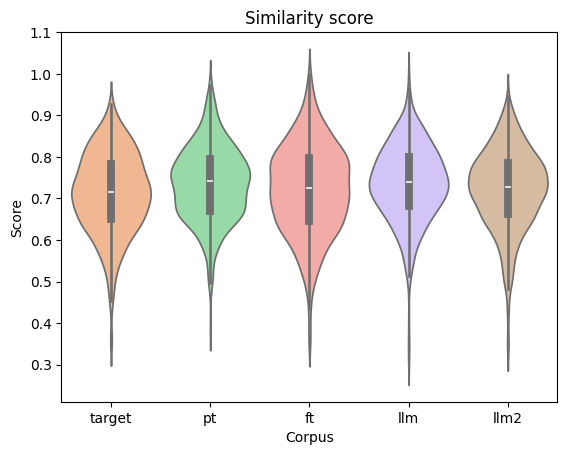

In [86]:
sns.violinplot(data=bert_df, palette=pal2)
# plt.ylim(0, 1)
plt.xlabel("Corpus")
plt.ylabel("Score")
plt.title("Similarity score")
plt.show()

In [87]:
# Backing-up
bert_df.to_csv(homepath + "/bert_df.csv")

In [88]:
bert_df = pd.read_csv(homepath + "/bert_df.csv", index_col = 0)

## Fluency

### Perplexity

In [89]:
# LM for estimating the generated text perplexity level
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load the model and tokenizer (e.g., GPT-2)
model_name = "gpt2"
perp_tokenizer = AutoTokenizer.from_pretrained(model_name)
perp_model = AutoModelForCausalLM.from_pretrained(model_name).to(device)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [90]:
# Assign the EOS token as the padding token
perp_tokenizer.pad_token = perp_tokenizer.eos_token


In [91]:
# the code taken from: https://www.comet.com/site/blog/perplexity-for-llm-evaluation/
# and modified slightly
def calculate_batch_perplexity(input_texts):
    """
    Calculate perplexity for a batch of input texts using a pretrained language model.

    Args:
    - input_texts (List[str]): A list of input texts to evaluate.

    Returns:
    - List[float]: A list of perplexity scores, one for each input text.
    """
    # Tokenize the batch of texts with padding for uniform length
    inputs = perp_tokenizer(
        input_texts, return_tensors="pt", padding=True, truncation=True
    )

    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    # Pass the input batch through the model to get logits
    with torch.no_grad():
        outputs = perp_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    # Shift the logits and input_ids to align targets correctly
    # Logits dimensions are: (batch_size, seq_length, vocab_size)
    shift_logits = logits[:, :-1, :]  # Ignore the last token's logits
    shift_labels = input_ids[:, 1:]   # Skip the first token in the labels

    # Compute log probabilities
    log_probs = torch.nn.functional.log_softmax(shift_logits, dim=-1)

    # Gather the log probabilities for the correct tokens
    target_log_probs = log_probs.gather(dim=-1, index=shift_labels.unsqueeze(-1)).squeeze(-1)

    # Mask out positions corresponding to padding tokens
    target_log_probs = target_log_probs * attention_mask[:, 1:].to(log_probs.dtype)

    # Compute the mean negative log-likelihood for each sequence
    negative_log_likelihood = -target_log_probs.sum(dim=-1) / attention_mask[:, 1:].sum(dim=-1)

    # Compute perplexity for each sequence
    perplexities = torch.exp(negative_log_likelihood)
    # perplexities = perplexities.tolist()
    fluency_score = 1 / perplexities

# Take mean of perplexities of each batch
    mean_perplexity_score = torch.mean(perplexities)

    return {"perplexities": perplexities.tolist(),
            "fluency": fluency_score.tolist(),
            "mean_perplexity": mean_perplexity_score.to("cpu").item()}


In [92]:
# Example usage
texts = [
    "The quick brown fox jumps over the lazy dog.",
    "A journey of a thousand miles begins with a single step."
]

In [93]:
print(f"Perplexity scores: {calculate_batch_perplexity(texts)}")

Perplexity scores: {'perplexities': [162.47267150878906, 30.061914443969727], 'fluency': [0.006154881324619055, 0.033264681696891785], 'mean_perplexity': 96.26729583740234}


In [94]:
example_texts = [
    "Once upon a time, there was a brave knight.",
    "In a galaxy far, far away, a new adventure began."
]

# Compute perplexity scores for the batch of input texts
results = calculate_batch_perplexity(example_texts)
print(f"Perplexity scores for each text: {results['perplexities']}")
print(f"Fluency scores: {results['fluency']}")
print(f"Mean perplexity score: {results['mean_perplexity']}")

Perplexity scores for each text: [25.60731315612793, 18.61147689819336]
Fluency scores: [0.03905134275555611, 0.05373028665781021]
Mean perplexity score: 22.109394073486328


In [95]:
# text perplexity DF
perp_df = pd.DataFrame(columns = test_df.columns)

# text fluency score DF: measured as 1 / PPL
fl_df = pd.DataFrame(columns = test_df.columns)

for index, row in test_df.iterrows():
    res = calculate_batch_perplexity(row.fillna("").to_list())
    perp_df.loc[index] = res['perplexities']
    fl_df.loc[index] = res["fluency"]

In [96]:
perp_df.head(12)

,source,target,pt,ft,llm,llm2
0,824.427124,15.619672,134.332382,52.544559,24.185104,53.208828
2,1719.302734,116.597137,38.146179,44.307648,227.214340,38.125786
3,818.972656,27.402431,106.897583,29.450487,458.944885,42.978481
4,932.161682,244.967697,955.943237,593.305420,785.046814,147.765549
5,410.590088,66.216347,120.514786,382.127777,59.652283,50.741249
6,1138.561523,34.860691,52.835819,61.722012,55.500881,26.026749
7,855.051392,47.327347,21.782312,40.828140,61.962284,38.518311
8,585.979797,300.099884,85.741699,50.885189,338.223572,90.211876
9,1177.112183,19.328072,36.952068,20.376972,69.171638,51.773216
10,2568.438232,19.877302,187.358276,139.210022,78.355576,102.643745


In [97]:
fl_df.head(12)

,source,target,pt,ft,llm,llm2
0,0.001213,0.064022,0.007444,0.019031,0.041348,0.018794
2,0.000582,0.008577,0.026215,0.022569,0.004401,0.026229
3,0.001221,0.036493,0.009355,0.033955,0.002179,0.023267
4,0.001073,0.004082,0.001046,0.001685,0.001274,0.006767
5,0.002436,0.015102,0.008298,0.002617,0.016764,0.019708
6,0.000878,0.028686,0.018927,0.016202,0.018018,0.038422
7,0.001170,0.021129,0.045909,0.024493,0.016139,0.025962
8,0.001707,0.003332,0.011663,0.019652,0.002957,0.011085
9,0.000850,0.051738,0.027062,0.049075,0.014457,0.019315
10,0.000389,0.050309,0.005337,0.007183,0.012762,0.009742


In [98]:
fl_df.describe()

,source,target,pt,ft,llm,llm2
count,581.000000,581.000000,581.000000,581.000000,522.000000,581.000000
mean,0.002628,0.026474,0.014138,0.019627,0.014716,0.016029
std,0.002265,0.020860,0.012247,0.016575,0.013250,0.012095
min,0.000022,0.000376,0.000233,0.000271,0.000066,0.000640
25%,0.001083,0.010925,0.005675,0.008249,0.007059,0.007712
50%,0.002226,0.021361,0.010883,0.015784,0.011775,0.013563
75%,0.003537,0.036761,0.019046,0.026784,0.019386,0.020286
max,0.029357,0.111385,0.112933,0.143842,0.166539,0.108758


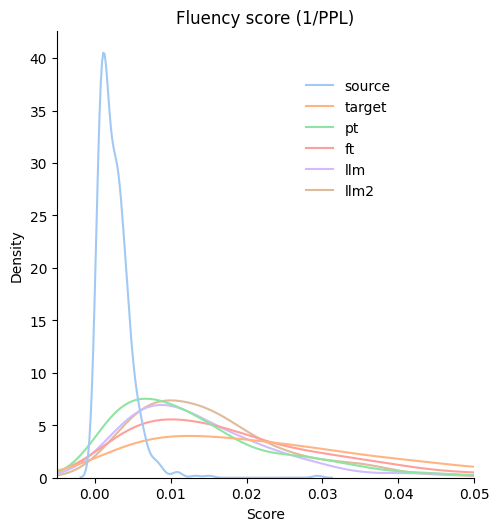

In [99]:
ax = sns.displot(data=fl_df, kind="kde", palette="pastel")
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.5, 0.9))
plt.xlim(-0.005, 0.05)
plt.xlabel("Score")
plt.title("Fluency score (1/PPL)")
plt.show()

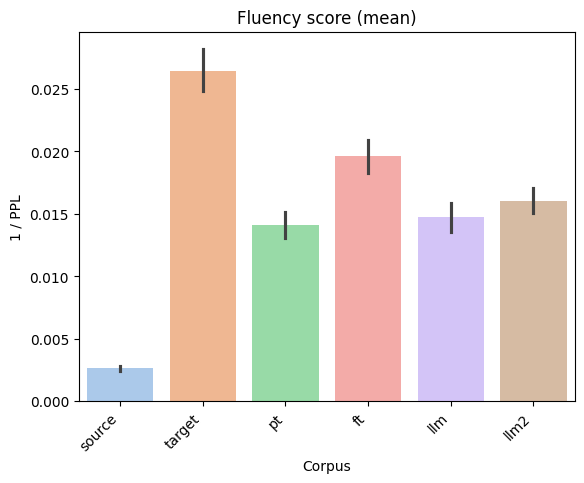

In [100]:
sns.barplot(data=fl_df, palette='pastel')
# plt.ylim(0, 1)
plt.xlabel("Corpus")
plt.ylabel("1 / PPL")
plt.xticks(rotation=45, ha='right')
plt.title("Fluency score (mean)")
plt.show()

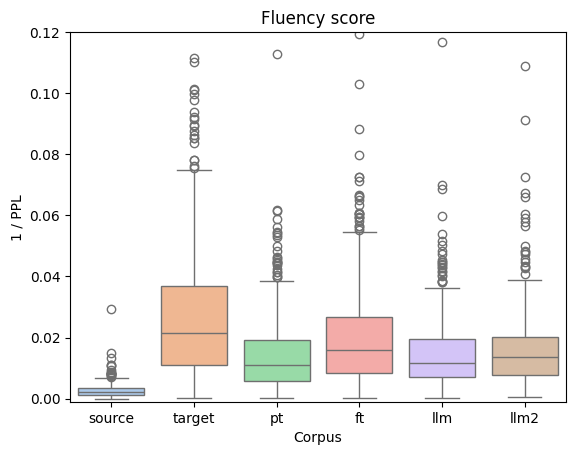

In [101]:
sns.boxplot(data=fl_df, palette="pastel")
plt.ylim(-.001, .12)
plt.xlabel("Corpus")
plt.ylabel("1 / PPL")
plt.title("Fluency score")
plt.show()

In [102]:
# Backing-up
fl_df.to_csv(homepath + "/fl_df.csv")
perp_df.to_csv(homepath + "/perp_df.csv")

In [103]:
fl_df = pd.read_csv(homepath + "/fl_df.csv", index_col = 0)
perp_df = pd.read_csv(homepath + "/perp_df.csv", index_col = 0)

### RoBERTa-large CoLA

In [104]:
# RoBERTa-large classifier trained on CoLA (The Corpus of Linguistic Acceptability)
from transformers import AutoTokenizer, AutoModelForSequenceClassification

cola_tokenizer = AutoTokenizer.from_pretrained("cointegrated/roberta-large-cola-krishna2020")
cola_model = AutoModelForSequenceClassification.from_pretrained("cointegrated/roberta-large-cola-krishna2020").to(device)

tokenizer_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/628 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

In [105]:
# CoLA: is the text linguistically acceptable
def cola_score(s):
    if isinstance(s, str) and len(s):
        inputs = cola_tokenizer(s, return_tensors="pt").input_ids.to(device)
        return np.argmin(cola_model(inputs).logits.softmax(1).detach().to("cpu").numpy(), axis=1).tolist()[0]
    else:
        return float('nan')

In [106]:
cola_score("This is a proper sentence.")

1

In [107]:
cola_score("He have an apple.")

0

In [108]:
cola_score("I was wanting too made shure.")

0

In [109]:
cola_score("")

nan

In [110]:
cola_df = pd.DataFrame(columns = test_df.columns)

for column in test_df:
    cola_df[column] = test_df[column].apply(cola_score)

In [111]:
cola_df.head(12)

,source,target,pt,ft,llm,llm2
index,,,,,,
0,1,1,1,1,1.0,1
2,0,1,1,1,1.0,1
3,1,1,0,1,1.0,1
4,0,1,0,1,0.0,1
5,0,1,1,1,1.0,1
6,0,1,1,1,1.0,1
7,1,1,1,1,1.0,1
8,0,1,1,1,1.0,1
9,1,1,1,1,1.0,1


In [112]:
cola_df.describe()

,source,target,pt,ft,llm,llm2
count,581.000000,581.000000,581.000000,581.000000,522.000000,581.000000
mean,0.693632,0.987952,0.905336,0.936317,0.973180,0.991394
std,0.461382,0.109195,0.293003,0.244398,0.161712,0.092447
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


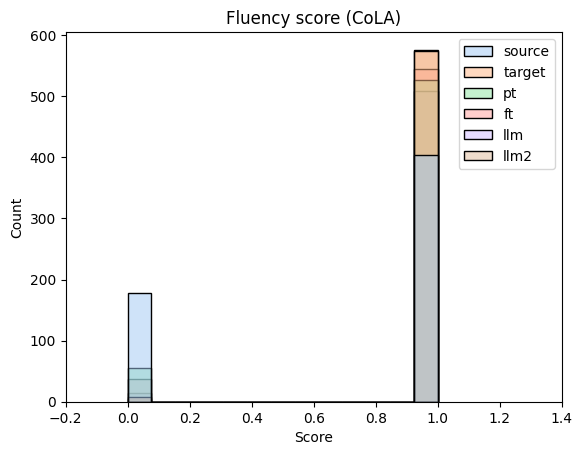

In [149]:
ax = sns.histplot(data=cola_df, palette="pastel")
# sns.move_legend(ax, "upper left", bbox_to_anchor=(0.15, 0.9))
plt.xlim(-0.2, 1.4)
plt.xlabel("Score")
plt.title("Fluency score (CoLA)")
plt.show()

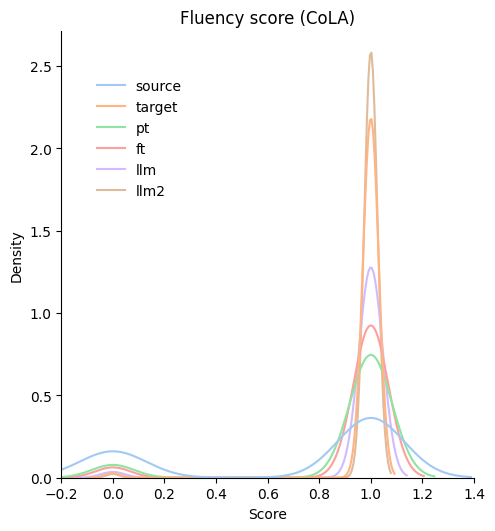

In [113]:
ax = sns.displot(data=cola_df, kind="kde", palette="pastel")
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.15, 0.9))
plt.xlim(-0.2, 1.4)
plt.xlabel("Score")
plt.title("Fluency score (CoLA)")
plt.show()

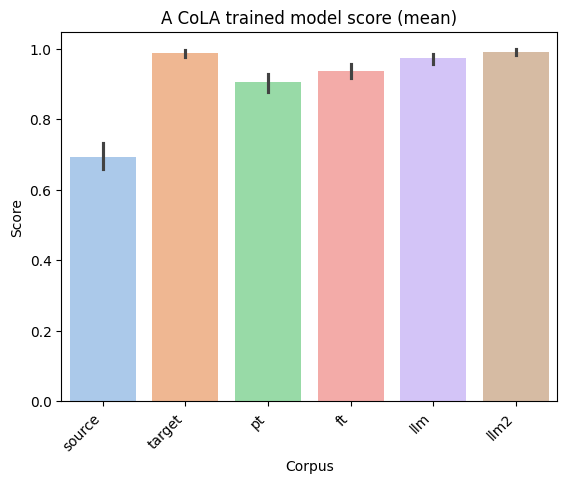

In [114]:
# cola_df.mean().plot(kind='bar')
sns.barplot(data=cola_df, palette='pastel')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Corpus")
plt.ylabel("Score")
plt.title("A CoLA trained model score (mean)")
plt.show()

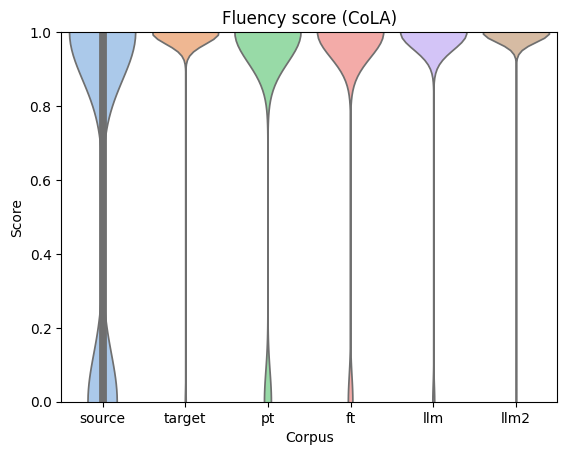

In [115]:
sns.violinplot(data=cola_df, palette="pastel")
plt.ylim(0, 1)
plt.xlabel("Corpus")
plt.ylabel("Score")
plt.title("Fluency score (CoLA)")
plt.show()

In [116]:
# Backing-up
cola_df.to_csv(homepath + "/cola_df.csv")

In [117]:
cola_df = pd.read_csv(homepath + "/cola_df.csv", index_col = 0)

## BART-score

https://huggingface.co/ZoneTwelve/BARTScore

https://github.com/neulab/BARTScore

In [118]:
%%capture
!wget https://raw.githubusercontent.com/neulab/BARTScore/refs/heads/main/bart_score.py

In [119]:
from bart_score import BARTScorer
bart_scorer = BARTScorer(device='cuda:0', checkpoint='facebook/bart-large-cnn')
# trained ParaBank version of BARTScore
bart_scorer.load(path = homepath + '/bart_score.pth')


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

In [120]:
bart_scorer.score(['This is interesting.'], ['This is fun.'], batch_size=4) # generation scores from the first list of texts to the second list of texts.


[-2.3362033367156982]

In [121]:
bart_scorer.score(["I love programming"], ["Coding is my passion"])

[-2.7384142875671387]

In [122]:
# BART score
def bart_score(src, tgt):
    # checking for NaN's
    if isinstance(tgt, str) and len(tgt):
        return bart_scorer.score([src], [tgt])[0]
    else:
        return float('nan')


In [123]:
bart_score("I love programming", "Coding is my passion")

-2.7384142875671387

In [124]:
bart_score("I love programming", "How is it going?")

-4.103177547454834

In [125]:
# similarity score DF
bart_df = pd.DataFrame()

for column in test_df:
    if column != "source":
        bart_df[column] = test_df.apply(lambda x: bart_score(x["source"], x[column]), axis=1)

In [126]:
bart_df.head(12)

,target,pt,ft,llm,llm2
index,,,,,
0,-1.721066,-3.042524,-3.913577,-1.535358,-1.792222
2,-3.932069,-2.615757,-3.455082,-4.295234,-2.718877
3,-1.526344,-2.923679,-1.450974,-2.292845,-2.841366
4,-2.243655,-1.626048,-1.409098,-2.023972,-4.053369
5,-2.418747,-2.449101,-3.413656,-3.063784,-4.405256
6,-2.477101,-2.335877,-3.255254,-3.837042,-2.908549
7,-3.332595,-2.274285,-3.190467,-2.258575,-2.407733
8,-2.098724,-2.024525,-2.031323,-3.543462,-2.425719
9,-3.244283,-3.017535,-2.057737,-4.348550,-3.664695


In [127]:
bart_df.describe()

,target,pt,ft,llm,llm2
count,581.000000,581.000000,581.000000,522.000000,581.000000
mean,-2.706166,-2.492212,-2.512724,-3.211562,-3.225129
std,0.789104,0.698225,0.822070,0.962677,0.909699
min,-5.615424,-4.979375,-5.487863,-7.272480,-6.492140
25%,-3.223171,-2.911832,-3.060561,-3.807653,-3.835463
50%,-2.694157,-2.442585,-2.450022,-3.209109,-3.171869
75%,-2.127549,-2.026050,-1.895322,-2.536457,-2.627089
max,-0.695798,-0.885413,-0.656429,-0.568443,-0.893013


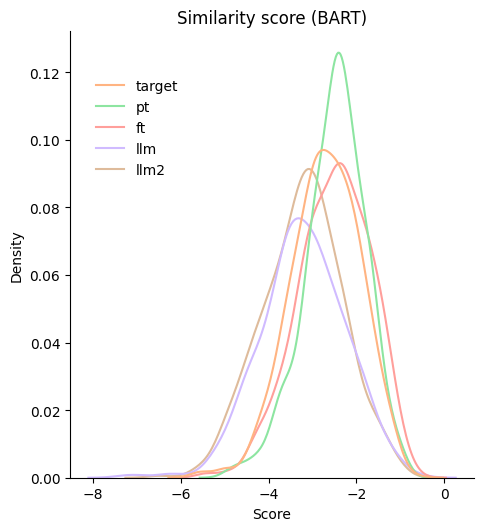

In [128]:
ax = sns.displot(data=bart_df, kind="kde", palette=pal2)
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.15, 0.9))
plt.xlabel("Score")
plt.title("Similarity score (BART)")
plt.show()

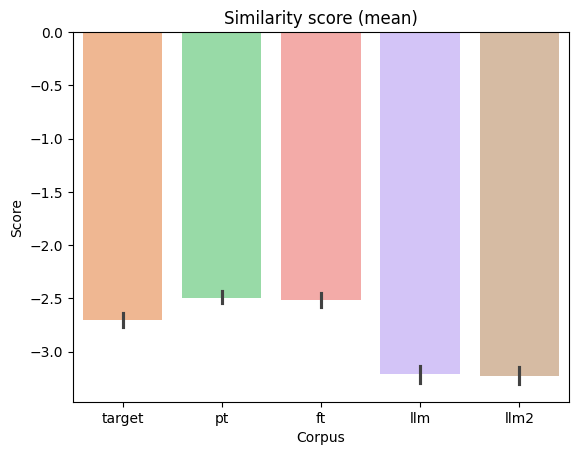

In [129]:
sns.barplot(data=bart_df, palette=pal2)
# plt.ylim(0, 1)
plt.xlabel("Corpus")
plt.ylabel("Score")
plt.title("Similarity score (mean)")
plt.show()

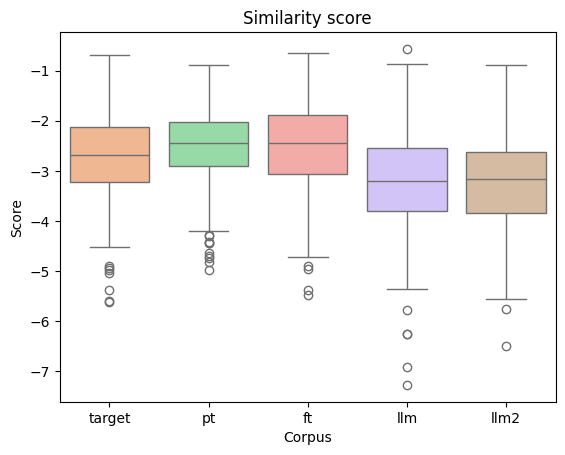

In [130]:
sns.boxplot(data=bart_df, palette=pal2)
# plt.ylim(0, 1)
plt.xlabel("Corpus")
plt.ylabel("Score")
plt.title("Similarity score")
plt.show()

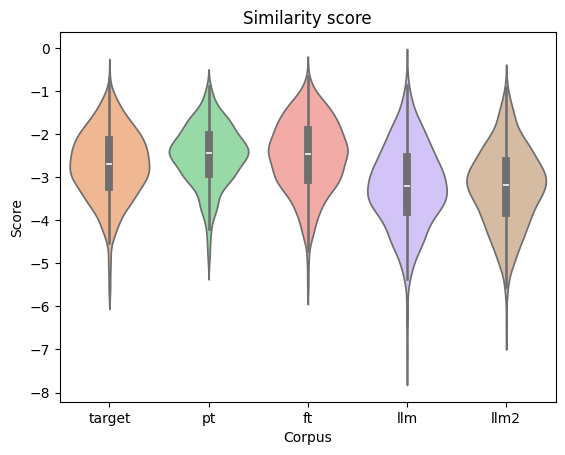

In [131]:
sns.violinplot(data=bart_df, palette=pal2)
# plt.ylim(0, 1)
plt.xlabel("Corpus")
plt.ylabel("Score")
plt.title("Similarity score")
plt.show()

In [132]:
# Backing-up
bart_df.to_csv(homepath + "/bart_df.csv")

In [133]:
bart_df = pd.read_csv(homepath + "/bart_df.csv", index_col = 0)

# Textual statistics

## Computing statistics

In [134]:
# calculating basic text statistics
def analyze_text(text):
    if isinstance(text, str) and len(text):
        words = text.split()
        num_words = len(words)
        total_length = sum(len(word) for word in words)
        mean_length = total_length / num_words if num_words > 0 else 0
        return total_length, num_words, mean_length
    else:
        return [float('nan')] * 3

text = "This is a sample sentence to test the function."
analyze_text(text)

(39, 9, 4.333333333333333)

In [135]:
# length of text strings in symbols
len_df = pd.DataFrame(columns = test_df.columns)
# no of words in text strings
numw_df = pd.DataFrame(columns = test_df.columns)
# mean word length in symbols
meanwl_df = pd.DataFrame(columns = test_df.columns)

for column in test_df:
    for i, s in enumerate(test_df[column]):
        res = analyze_text(s)
        len_df.loc[i, column] = res[0]
        numw_df.loc[i, column] = res[1]
        meanwl_df.loc[i, column] = res[2]

In [136]:
len_df

,source,target,pt,ft,llm,llm2
0,23,42,21,29,27,27
1,41,38,79,63,65,66
2,36,54,45,53,51,70
3,39,47,34,43,45,51
4,46,83,65,38,94,133
...,...,...,...,...,...,...
576,70,61,73,73,122,131
577,47,81,67,47,118,63
578,105,102,123,137,212,157
579,64,74,74,84,82,119


## Comparing LMs and LLMs

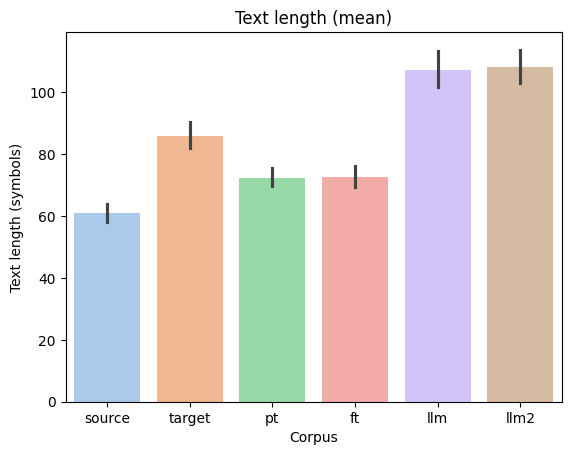

In [137]:
sns.barplot(data=len_df, palette='pastel')
# plt.xticks(rotation=45, ha='right')
plt.xlabel("Corpus")
plt.ylabel("Text length (symbols)")
plt.title("Text length (mean)")
plt.show()

In [34]:
# Welch’s t-test:
# H0 = no difference between the NN models and LLMs
t_result = ttest_ind(len_df.pt + len_df.ft, (len_df.llm + len_df.llm2).dropna(),
                     equal_var=False,
                     alternative='less')
print(f"T-statistic: {t_result.statistic}")
print(f"P-value: {t_result.pvalue}")

T-statistic: -10.888239528046453
P-value: 3.53508089802924e-26


In [27]:
((len_df.pt + len_df.ft) / 2).mean()

np.float64(72.50688468158347)

In [28]:
((len_df.llm + len_df.llm2) / 2).mean()

np.float64(106.18486590038314)

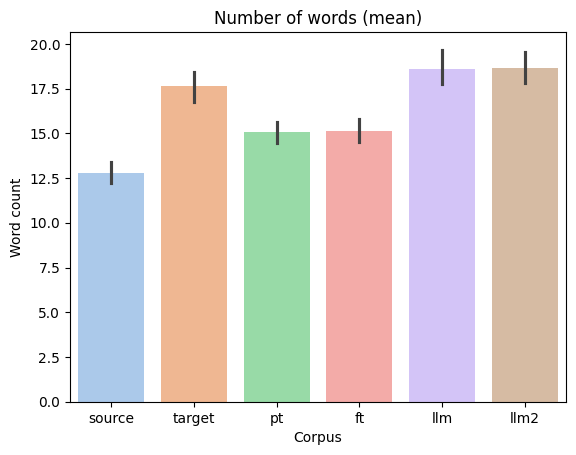

In [138]:
sns.barplot(data=numw_df, palette='pastel')
# plt.xticks(rotation=45, ha='right')
plt.xlabel("Corpus")
plt.ylabel("Word count")
plt.title("Number of words (mean)")
plt.show()

In [35]:
# Welch’s t-test:
# H0 = no difference between the NN models and LLMs
t_result = ttest_ind(numw_df.pt + numw_df.ft, (numw_df.llm + numw_df.llm2).dropna(),
                     equal_var=False,
                     alternative='less')
print(f"T-statistic: {t_result.statistic}")
print(f"P-value: {t_result.pvalue}")

T-statistic: -6.181419525873995
P-value: 4.728230768130312e-10


In [29]:
((numw_df.pt + numw_df.ft) / 2).mean()

np.float64(15.110154905335628)

In [30]:
((numw_df.llm + numw_df.llm2) / 2).mean()

np.float64(18.409961685823756)

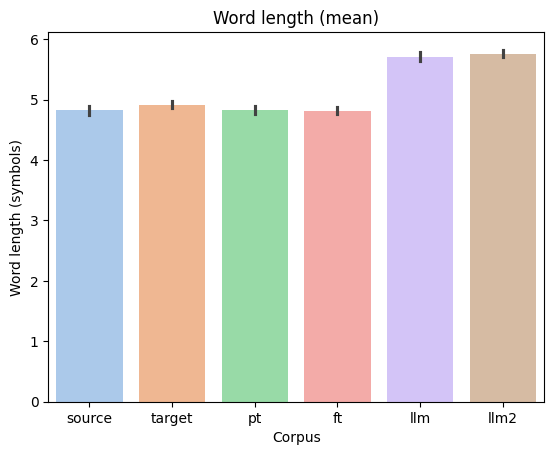

In [139]:
sns.barplot(data=meanwl_df, palette='pastel')
# plt.xticks(rotation=45, ha='right')
plt.xlabel("Corpus")
plt.ylabel("Word length (symbols)")
plt.title("Word length (mean)")
plt.show()

In [36]:
# Welch’s t-test:
# H0 = no difference between the NN models and LLMs
t_result = ttest_ind(meanwl_df.pt + meanwl_df.ft, (meanwl_df.llm + meanwl_df.llm2).dropna(),
                     equal_var=False,
                     alternative='less')
print(f"T-statistic: {t_result.statistic}")
print(f"P-value: {t_result.pvalue}")

T-statistic: -21.734414429434523
P-value: 4.4185907734542585e-86


In [31]:
((meanwl_df.pt + meanwl_df.ft) / 2).mean()

np.float64(4.822034917238698)

In [32]:
((meanwl_df.llm + meanwl_df.llm2) / 2).mean()

np.float64(5.723300122780718)

## Correlation test

In [140]:
# checking of there's a correlation between the text statistics and the formality level
# text length vs formality level
pearsonr(len_df.mean().to_list(), form_df.mean().to_list())

PearsonRResult(statistic=np.float64(0.7669690505402948), pvalue=np.float64(0.07512794595152053))

In [21]:
# no of words vs formality level
pearsonr(numw_df.mean().to_list(), form_df.mean().to_list())

PearsonRResult(statistic=np.float64(0.8748969953709489), pvalue=np.float64(0.02249716398991845))

In [142]:
# mean word length vs formality level
pearsonr(meanwl_df.mean().to_list(), form_df.mean().to_list())

PearsonRResult(statistic=np.float64(0.5374749359435325), pvalue=np.float64(0.27142028953483954))

In [143]:
x, y = numw_df.mean().to_numpy().astype(float), form_df.mean().to_numpy()

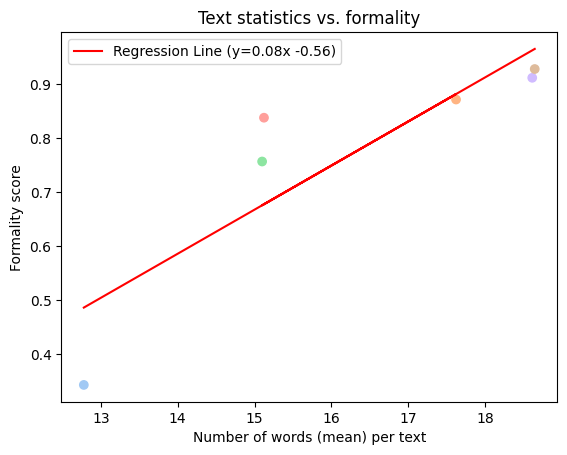

In [144]:
# linear regression
plt.scatter(x, y, c=sns.color_palette("pastel")[:6])
m, b = np.polyfit(x, y, 1) # Calculate slope and intercept
plt.plot(x, m * x + b, color='red', label=f'Regression Line (y={m:.2f}x {b:.2f})')
plt.xlabel("Number of words (mean) per text")
plt.ylabel("Formality score")
plt.title("Text statistics vs. formality")
plt.legend()
plt.show()

In [145]:
# Backing-up
len_df.to_csv(homepath + "/len_df.csv")
numw_df.to_csv(homepath + "/numw_df.csv")
meanwl_df.to_csv(homepath + "/meanwl_df.csv")

In [11]:
len_df = pd.read_csv(homepath + "/len_df.csv", index_col = 0)
numw_df = pd.read_csv(homepath + "/numw_df.csv", index_col = 0)
meanwl_df = pd.read_csv(homepath + "/meanwl_df.csv", index_col = 0)